# Vision Zero Data Dive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline

In [3]:
exp = pd.read_csv('OBJ1_streets_exposure.csv')

In [4]:
exp.head()

,Unnamed: 0,compkey,unitidsort,onstreet,unitdesc,streettype,sgndbkrout,pvmtcondin,mjtrk_str,artdescrip,...,res1_cnt,res2_cnt,vac_cnt,commu_cnt,inst_cnt,os_cnt,unkn_cnt,mid_x,mid_y,adt
0,0,14202,111550150,E INTERLAKEN BLVD,E INTERLAKEN BLVD BETWEEN DELMAR DR E AND INTE...,NaN,Y,25,False,Not Designated,...,43,1,8,0,2,0,0,-122.313591,47.638960,NaN
1,1,4934,23750010,32ND AVE E,32ND AVE E BETWEEN E DENNY N WAY AND E JOHN ST,Local,N,71,False,Collector Arterial,...,27,2,2,0,0,4,0,-122.291238,47.619515,NaN
2,2,17422,135200465,NE 70TH ST,NE 70TH ST BETWEEN 47TH W AVE NE AND 47TH E AV...,Local,N,76,False,Collector Arterial,...,15,0,1,0,1,0,0,-122.278236,47.679410,NaN
3,3,2560,8450240,18TH AVE E,18TH AVE E BETWEEN E MCGRAW ST AND E CALHOUN ST,NaN,Y,83,False,Not Designated,...,19,0,0,0,0,1,0,-122.308983,47.640651,NaN
4,4,16682,131450080,NE 145TH ST,NE 145TH ST BETWEEN 8TH AVE NE AND 10TH AVE NE,Regional,N,68,True,Principal Arterial,...,14,0,0,0,0,1,0,-122.319458,47.734015,NaN


## Just use rows that have values for adt (average daily traffic)

In [5]:
df = exp[np.isfinite(exp['adt'])]

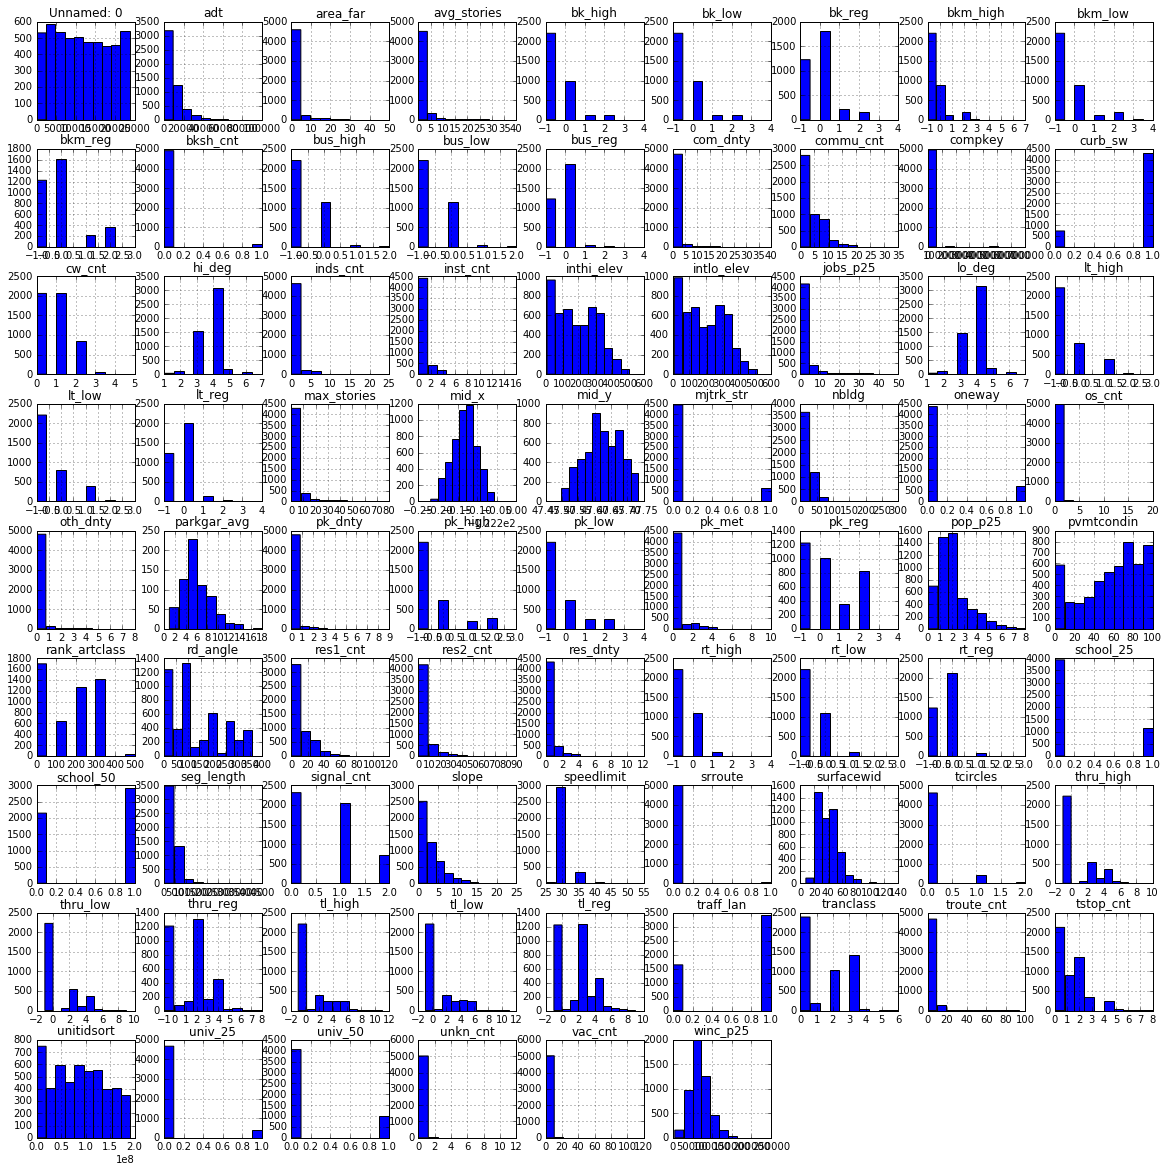

In [6]:
df.hist(figsize=(20,20))
plt.show()

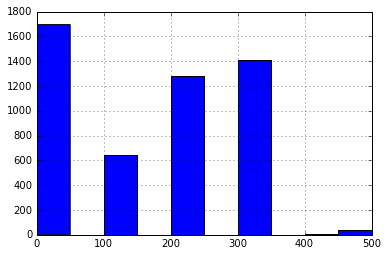

In [7]:
df.rank_artclass.hist()
plt.show()

In [8]:
df.shape

(5066, 93)

## Filter out non-numerical data columns

In [9]:
#no objects, just numbers
noobj = df.select_dtypes(exclude=[object])
noobj.shape

(5066, 78)

In [10]:
data = noobj.ix[:, noobj.columns != 'adt']
data = data.fillna(value=0)  # fill in nans with zero

In [11]:
data.head()

,Unnamed: 0,compkey,unitidsort,pvmtcondin,mjtrk_str,rank_artclass,surfacewid,oneway,tranclass,speedlimit,...,inds_cnt,res1_cnt,res2_cnt,vac_cnt,commu_cnt,inst_cnt,os_cnt,unkn_cnt,mid_x,mid_y
6,6,1011,100190,73,False,200,52,False,2,30,...,0,0,4,0,11,0,0,0,-122.341962,47.610684
12,12,1931,4650220,36,False,100,42,False,3,30,...,0,13,15,0,1,0,0,0,-122.314695,47.583342
26,26,8730,50450230,74,True,300,47,False,3,30,...,0,0,0,1,9,2,0,0,-122.350021,47.612187
28,28,19649,155900080,95,False,300,42,False,3,30,...,0,14,16,2,1,3,0,5,-122.321600,47.526461
32,32,18441,145400320,92,False,200,30,False,3,30,...,0,0,5,1,4,2,0,0,-122.398977,47.667471


In [12]:
# all the data that is not object dtype
X_train = np.array(data)
# OR just a few columns...
#X_train = np.array(data[['tranclass','rank_artclass', 'slope']])
#np.where(np.isfinite(X_train) == False)

In [13]:
X_train

array([[6, 1011, 100190, ..., 0.0, -122.341962263, 47.6106836074],
       [12, 1931, 4650220, ..., 0.0, -122.31469522299999, 47.5833419249],
       [26, 8730, 50450230, ..., 0.0, -122.350020753, 47.6121871535],
       ..., 
       [23756, 11876, 86650140, ..., 0.0, -122.32736021299999, 47.613438162],
       [23765, 9759, 60750620, ..., 0.0, -122.31228348299999,
        47.548061151000006],
       [23768, 1682, 3400600, ..., 0.0, -122.317314221, 47.548929465]], dtype=object)

In [14]:
Y_train = np.array(df['adt'])
Y_train

array([ 19396.,   8972.,  13492., ...,   1488.,   1165.,   1268.])

In [15]:
print(X_train.shape)
print(Y_train.shape)

(5066, 77)
(5066,)


In [16]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor

In [17]:
model = RandomForestRegressor(n_estimators = 10)

## Baseline of R$^2$~80% for all numerical data
- non-finite values filled in with zeros
- no feature scaling

In [18]:
scores = cross_validation.cross_val_score(model, X_train, y=Y_train, cv=10, scoring='r2')
scores.mean()

0.7939267847664716

## Try log-transform of adt (Y_train)

In [19]:
Y_train_log = np.log(Y_train)
scores = cross_validation.cross_val_score(model, X_train, y=Y_train_log, cv=10, scoring='r2')
scores.mean()

0.82165999788351252

## Scale the training data

In [20]:
from sklearn import preprocessing

In [21]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_train_transformed

/Users/jesford/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jesford/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-1.6691064 , -0.31961396, -1.60088415, ..., -0.12672938,
        -0.31806995, -0.24828775],
       [-1.66824103, -0.30446719, -1.51726867, ..., -0.12672938,
         0.57075839, -0.743069  ],
       [-1.66622186, -0.19252927, -0.67560611, ..., -0.12672938,
        -0.58075391, -0.22107924],
       ..., 
       [ 1.75628107, -0.14073391, -0.0103637 , ..., -0.12672938,
         0.15791556, -0.19844071],
       [ 1.75757911, -0.17558794, -0.48631679, ..., -0.12672938,
         0.64937429, -1.38151785],
       [ 1.75801179, -0.3085667 , -1.54023282, ..., -0.12672938,
         0.48538647, -1.36580464]])

In [22]:
scores = cross_validation.cross_val_score(model, X_train_transformed, 
                                          y=Y_train_log, cv=10, scoring='r2')
scores.mean()

0.82072360795244104

## Feature Importance

In [23]:
model.fit(X_train_transformed, y=Y_train_log)
importances = model.feature_importances_

In [24]:
importances

array([  6.63784082e-03,   6.39616199e-03,   8.20096911e-03,
         8.02857211e-03,   3.28857593e-03,   5.85491393e-01,
         1.14733325e-02,   1.83739764e-02,   3.99625343e-03,
         1.26246892e-01,   1.32529304e-02,   5.18952951e-03,
         5.83684531e-03,   7.25337352e-03,   7.11293145e-04,
         4.90474755e-04,   6.95881584e-04,   1.85983659e-04,
         3.70146550e-03,   4.06220356e-03,   7.47671039e-03,
         5.96006521e-04,   1.42432114e-03,   1.38214428e-03,
         1.01747198e-02,   1.10495871e-03,   1.98332159e-04,
         2.15021453e-04,   1.07626448e-03,   7.08983409e-04,
         7.99282990e-04,   3.11521925e-04,   1.03476275e-03,
         1.37288987e-03,   6.65456718e-04,   3.03484645e-04,
         1.76858209e-03,   4.76335418e-05,   5.95803119e-05,
         3.35562473e-04,   2.45131183e-04,   2.57807440e-05,
         3.18566889e-04,   1.89208308e-04,   2.23856196e-04,
         4.24523112e-04,   5.78095787e-05,   1.87955167e-04,
         2.84939429e-04,

In [25]:
data.columns.values[1:]

array(['compkey', 'unitidsort', 'pvmtcondin', 'mjtrk_str', 'rank_artclass',
       'surfacewid', 'oneway', 'tranclass', 'speedlimit', 'seg_length',
       'inthi_elev', 'intlo_elev', 'slope', 'school_50', 'school_25',
       'univ_50', 'univ_25', 'hi_deg', 'lo_deg', 'cw_cnt', 'tcircles',
       'signal_cnt', 'curb_sw', 'rd_angle', 'traff_lan', 'pk_high',
       'pk_low', 'pk_reg', 'pk_met', 'parkgar_avg', 'tl_high', 'tl_low',
       'tl_reg', 'thru_high', 'thru_low', 'thru_reg', 'bus_high',
       'bus_low', 'bus_reg', 'bk_high', 'bk_low', 'bk_reg', 'bkm_high',
       'bkm_low', 'bkm_reg', 'bksh_cnt', 'lt_high', 'lt_low', 'lt_reg',
       'rt_high', 'rt_low', 'rt_reg', 'troute_cnt', 'tstop_cnt', 'srroute',
       'pop_p25', 'jobs_p25', 'winc_p25', 'com_dnty', 'oth_dnty',
       'res_dnty', 'pk_dnty', 'area_far', 'nbldg', 'max_stories',
       'avg_stories', 'inds_cnt', 'res1_cnt', 'res2_cnt', 'vac_cnt',
       'commu_cnt', 'inst_cnt', 'os_cnt', 'unkn_cnt', 'mid_x', 'mid_y'], dtype=obje

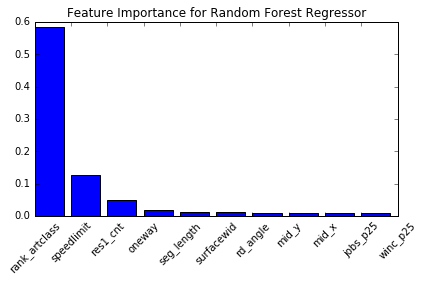

In [26]:
order = np.argsort(importances)[::-1]
order
plt.bar(range(X_train.shape[1]), importances[order])
plt.xticks(range(X_train.shape[1]), data.columns.values[order], rotation=45)
plt.xlim([0,10])
plt.title('Feature Importance for Random Forest Regressor')
plt.tight_layout()
plt.savefig('feature_importance.png')

In [27]:
X_train.shape

(5066, 77)

## Adding some categorical data

In [28]:
yesobj = df.select_dtypes(include=[object])
yesobj.columns

Index(['onstreet', 'unitdesc', 'streettype', 'sgndbkrout', 'artdescrip',
       'ml_traff_lan', 'lanetyps', 'pkg', 'parkgar', 'bk_lane', 'bkm_lane',
       'lt_lane', 'rt_lane', 'medr', 'onoff_rp'],
      dtype='object')

### Don't care about:
- onstreet: street name
- unitdesc: street name descr
- 

In [29]:
yesobj['onstreet']

6                     1ST AVE
12                 14TH AVE S
26                ALASKAN WAY
28            S CLOVERDALE ST
32                 NW 54TH ST
39               HOLMAN RD NW
43                 NE 80TH ST
44            S WASHINGTON ST
46                S WELLER ST
48                 NE 40TH ST
50                  5TH AVE S
58             S HENDERSON ST
61               SW HUDSON ST
64                 18TH AVE S
65           NE NORTHGATE WAY
66               DAYTON AVE N
67                 21ST AVE E
77            DELRIDGE WAY SW
78                W DRAVUS ST
83                 NE 69TH ST
101                NE 50TH ST
103      SW ADMIRAL WY OFF RP
114                 THOMAS ST
116            RAVENNA AVE NE
117            SW ADMIRAL WAY
124               26TH AVE NW
128                NE 42ND ST
158                NW 58TH ST
165                15TH AVE W
181                 DENNY WAY
                 ...         
23583              23RD AVE S
23586       M L KING JR WAY S
23590     

In [30]:
data.columns.values[order]

array(['rank_artclass', 'speedlimit', 'res1_cnt', 'oneway', 'seg_length',
       'surfacewid', 'rd_angle', 'mid_y', 'mid_x', 'jobs_p25', 'winc_p25',
       'unitidsort', 'pvmtcondin', 'cw_cnt', 'area_far', 'slope',
       'com_dnty', 'pop_p25', 'Unnamed: 0', 'compkey', 'res_dnty',
       'intlo_elev', 'avg_stories', 'inthi_elev', 'troute_cnt', 'nbldg',
       'lo_deg', 'tranclass', 'hi_deg', 'mjtrk_str', 'max_stories',
       'oth_dnty', 'commu_cnt', 'res2_cnt', 'vac_cnt', 'tstop_cnt',
       'thru_reg', 'signal_cnt', 'curb_sw', 'tl_reg', 'inst_cnt', 'os_cnt',
       'traff_lan', 'pk_reg', 'tl_low', 'inds_cnt', 'pk_dnty',
       'parkgar_avg', 'school_50', 'pk_met', 'univ_50', 'thru_high',
       'tcircles', 'school_25', 'bkm_reg', 'bus_reg', 'bk_reg', 'tl_high',
       'thru_low', 'lt_low', 'rt_reg', 'bk_high', 'bkm_low', 'pk_low',
       'pk_high', 'bkm_high', 'lt_high', 'univ_25', 'unkn_cnt', 'lt_reg',
       'rt_high', 'rt_low', 'bus_low', 'bksh_cnt', 'bus_high', 'bk_low',
       '